In [1]:
import numpy as np
import pandas as pd
import pickle
import sys

input_data = pd.read_pickle('../dados/df_ata_sentimento.pkl') 
#input_data = pd.read_json('../dados/df_ata_sentimento.json', orient='records', lines=True)
#input_data['Data'] = pd.to_datetime(input_data['Data']).dt.date
#input_data.tail()
# A obtenção de dados da coluna Selic 6m dixa lacunas, limpar os dados:
input_data = input_data.dropna(subset=['Sentimento','Texto'])
input_data = input_data[~(input_data['Texto'].str.strip().isna() | (input_data['Texto'].str.strip() == ''))]
input_data['Texto'] = input_data['Texto'].str.lower()

input_data.sample(5)




,Data,Texto,Selic,IPCA,Selic (6m),Sentimento
92,2007-07-18,sumário evolução recente da economia avaliação...,12.00,3.74,11.25,dovish
100,2008-07-23,sumário evolução recente da economia avaliação...,12.25,6.37,13.75,hawkish
150,2014-10-29,sumário evolução recente da economia avaliação...,11.00,6.59,12.75,hawkish
117,2010-09-01,sumário evolução recente da economia avaliação...,10.75,4.49,11.25,hawkish
28,2001-10-17,sumário atividade econômica ambiente externo p...,19.00,7.19,19.00,neutral


In [2]:
base_data = input_data[['Texto','Sentimento']]
base_data.sample(10)
filename_root = 'sentimento_6m'
subset_dir = '../../subsets/'
basepickle = subset_dir + filename_root + '__base.pkl'
base_data.to_pickle(basepickle)
pd.read_pickle(basepickle).sample(5)


,Texto,Sentimento
150,sumário evolução recente da economia avaliação...,hawkish
42,sumário atividade econômica ambiente externo p...,hawkish
233,a atualização da conjuntura econômica e do cen...,hawkish
146,sumário evolução recente da economia avaliação...,hawkish
64,sumário evolução recente da inflação avaliação...,hawkish


In [3]:
from sklearn.preprocessing import LabelEncoder
#tratamento dos dados para modelo
training_data = base_data.copy()
#Encoding do label alfanumérico
label_encoder = LabelEncoder()
training_data.loc[:, 'sent_encoded'] = label_encoder.fit_transform(training_data['Sentimento'])


# Criando 3 colnuas com hot encoding
one_hot = pd.get_dummies(training_data['Sentimento'], prefix='sent')
training_data = pd.concat([training_data, one_hot], axis=1)

# Renomeando colunas
training_data = training_data.rename(columns={'Texto': 'text'})
training_data = training_data.rename(columns={'Sentimento': 'sent'})

# Display the result
print(training_data.sample(5))



                                                  text     sent  sent_encoded  \
131  sumário evolução recente da economia avaliação...   dovish             0   
135  sumário evolução recente da economia avaliação...  hawkish             1   
122  sumário evolução recente da economia avaliação...  hawkish             1   
72   sumário evolução recente da inflação avaliação...  hawkish             1   
93   sumário evolução recente da economia avaliação...   dovish             0   

     sent_dovish  sent_hawkish  sent_neutral  
131         True         False         False  
135        False          True         False  
122        False          True         False  
72         False          True         False  
93          True         False         False  


In [4]:
# Concatenando todas as atas

all_text = ' '.join(training_data['text'].tolist())

words = pd.Series(all_text.split())

# Contando as palavras únicas

word_count = words.nunique()

print(f"Palavras únicas na base: {word_count}")


Palavras únicas na base: 16738


In [5]:

# Switch de qual label vai ser estudado.
label_set = 'sent_encoded'
#label_set = 'sent_dovish'
#label_set = 'sent_hawkish'
#label_set = 'sent_neutral'

#Globais de processsamento
rnd_seed = 42
num_epochs = 150
num_batches = 16
token_count = 30000
padding_size = 80000
val_split = 0.2


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenizando para 30000 palavras, o dobro do medido na base
tokenizer = Tokenizer(num_words=token_count, oov_token='<OOV>')
tokenizer.fit_on_texts(training_data['text'])

# Save the tokenizer to a file

token_filename = subset_dir + filename_root + '__tokenizer.pkl'

with open(token_filename, 'wb') as file:
    pickle.dump(tokenizer, file)

# Preenchendo com 80000 caracterse, englobando o tamanho de todas as atas com alguma folga

sequences = tokenizer.texts_to_sequences(training_data['text'])
padded_sequences = pad_sequences(sequences, maxlen=padding_size)

print(padded_sequences)

print("{:.2f}".format(sys.getsizeof(padded_sequences)/(1024*1024)),'MB')
print(padded_sequences[0])

[[   0    0    0 ... 2975    7   31]
 [   0    0    0 ... 2065    7   31]
 [   0    0    0 ... 2975    7   31]
 ...
 [   0    0    0 ...   10    4   16]
 [   0    0    0 ...   10    4   16]
 [   0    0    0 ...   10    4   16]]
62.87 MB
[   0    0    0 ... 2975    7   31]


In [7]:


# Splitting the data into features (X) and labels (y)
X = padded_sequences
y = training_data[label_set].values

print(X[:5])
print(y[:5])

[[   0    0    0 ... 2975    7   31]
 [   0    0    0 ... 2065    7   31]
 [   0    0    0 ... 2975    7   31]
 [   0    0    0 ... 2975    7   31]
 [   0    0    0 ... 2975    7   31]]
[0 0 0 0 2]


In [8]:
#Salvando X e y completos para eventual uso
X_filename = subset_dir + filename_root + '_' + label_set + '_X_full.npy'
np.save(X_filename, X)

y_filename = subset_dir + filename_root + '_' + label_set + '_y_full.npy'
np.save(y_filename, y)



In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rnd_seed)

#Salvando conjuntos de treino e teste para uso posterior

X_test_filename = subset_dir + filename_root +  '_' + label_set + '_X_test.npy'
np.save(X_test_filename, X_test)
X_train_filename = subset_dir + filename_root +  '_' + label_set + '_X_train.npy'
np.save(X_train_filename, X_train)

y_test_filename = subset_dir + filename_root + '_' + label_set + '_y_test.npy'
np.save(y_test_filename, y_test)
y_train_filename = subset_dir + filename_root + '_' + label_set + '_y_train.npy'
np.save(y_train_filename, y_train)

print(X_train[:5])
print(X_test[:5])
print(y_train[:5])
print(y_test[:5])



[[   0    0    0 ...   25  244  118]
 [   0    0    0 ...  213    5  229]
 [   0    0    0 ... 6293  401   93]
 [   0    0    0 ...    7  244  118]
 [   0    0    0 ...    7   86   64]]
[[   0    0    0 ...   31    3 3260]
 [   0    0    0 ... 2975    7   31]
 [   0    0    0 ...   10    4   16]
 [   0    0    0 ... 2192    5 2134]
 [   0    0    0 ...    8  949  316]]
[1 0 1 1 1]
[0 0 1 0 1]


In [10]:
# Para sent_encoded com 3 valores, 0, 1 e 2.
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(token_count, 16),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes
])

ckptname = '../../' + filename_root +  '_' + label_set+ '_' + str(num_epochs) + '_CHKP_drlee_ata.keras'
# Define callback to save the best model based on validation loss
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    ckptname,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # For integer labels (0, 1, 2)
    metrics=['accuracy']
)

#history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32,callbacks=[checkpoint_cb])
history = model.fit(X_train, y_train, epochs=num_epochs, validation_split=val_split,callbacks=[checkpoint_cb])

Epoch 1/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1475s 290s/step - accuracy: 0.3893 - loss: 1.0971 - val_accuracy: 0.4242 - val_loss: 1.0926
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1568s 314s/step - accuracy: 0.5802 - loss: 1.0882 - val_accuracy: 0.5152 - val_loss: 1.0831
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1576s 304s/step - accuracy: 0.4962 - loss: 1.0770 - val_accuracy: 0.5152 - val_loss: 1.0669
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1442s 280s/step - accuracy: 0.4962 - loss: 1.0541 - val_accuracy: 0.5152 - val_loss: 1.0251
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1553s 305s/step - accuracy: 0.4962 - loss: 0.9905 - val_accuracy: 0.5152 - val_loss: 0.9637
Epoch 6/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1466s 290s/step - accuracy: 0.4198 - loss: 0.9584 - val_accuracy: 0.4848 - val_loss: 0.9724
Epoch 7/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1505s 289s/step - accuracy: 0.6260 - loss: 0.9200 - val_accuracy: 0.5152 - val_loss: 0.9514
Epoch 8/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 1613s 326s/step - accuracy: 0.4962 - loss: 0.9390 - val_accu

In [11]:
import keras
model_filename = '../../' + filename_root +  '_' + label_set+'_' + str(num_epochs) + '_drlee_ata.keras'
print(model_filename)
keras.saving.save_model(model, model_filename)

../../sentimento_6m_sent_encoded_150_drlee_ata.keras


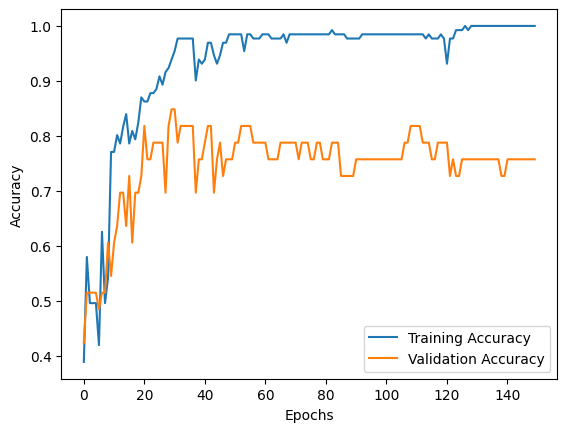

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.6905 - loss: 1.8659
Test Accuracy: 0.69


In [20]:


predictions = model.predict(X_test)



2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
[0 0 1 0 0 1 2 2 1 2 1 0 1 1 0 1 1 1 0 1 1 1 1 0 2 0 1 0 0 1 1 2 1 1 1 0 2
 0 1 1 1 1]


In [21]:
y_pred = tf.argmax(predictions, axis=1).numpy() 

y_true = y_test

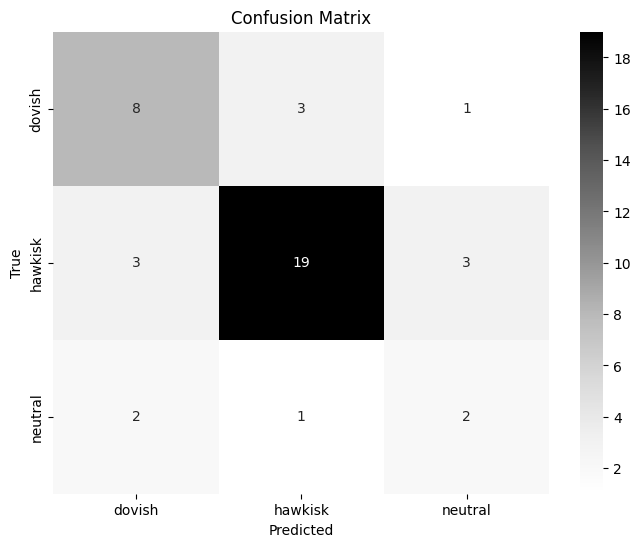

Confusion Matrix:
 [[ 8  3  1]
 [ 3 19  3]
 [ 2  1  2]]
Classification Report:
              precision    recall  f1-score   support

      dovish       0.62      0.67      0.64        12
     hawkisk       0.83      0.76      0.79        25
     neutral       0.33      0.40      0.36         5

    accuracy                           0.69        42
   macro avg       0.59      0.61      0.60        42
weighted avg       0.71      0.69      0.70        42



In [24]:
#0 = dovish
#1 = hawkisk
#2 = neutral

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Step 2: Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Visualize the confusion matrix (optional)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Grays', 
            xticklabels=['dovish', 'hawkisk', 'neutral'], 
            yticklabels=['dovish', 'hawkisk', 'neutral'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print the confusion matrix
print("Confusion Matrix:\n", cm)
from sklearn.metrics import classification_report
# Define the labels
labels = ['dovish', 'hawkisk', 'neutral']

# Generate classification report
report = classification_report(y_true, y_pred, target_names=labels)

# Print the classification report
print("Classification Report:")
print(report)